In [2]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
# import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
import pandas as pd
import datetime

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [4]:
past_sales = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv')
store = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

past_sales['Date'] = pd.to_datetime(past_sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
# a = 공휴일, b = 부활절 공휴일, c = 크리스마스, d = 없음
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
past_sales['StateHoliday'] = past_sales['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
past_sales = past_sales.sort_values('Date') # date 기준으로 정렬
# past_sales = pd.get_dummies(data = past_sales,columns=['StateHoliday']) # StateHoliday를 더미 가변수로 대체, 결측값 없다는 거 확인 완료

store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
# store = pd.get_dummies(data = store, columns = ['Assortment']) # 규모를 더미 가변수로 대체, storetype = a에는 규모가 b인 상점은 없음

# 결측값 확인 : past_sales.isnull().sum(), store_a.isnull().sum()
# store의 CompetitionDistance에 3개 있음
# 결측값 : 평균으로 대체
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean())

# 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')
# data = pd.get_dummies(data = data, columns = ['DayOfWeek']) # 요일 더미의 가변수로 추가
# data = pd.get_dummies(data = data, columns = ['StoreType'])
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1) # 그래프 그릴려고 잠시 제거한 코드

pd.options.display.max_columns = None

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(data.StateHoliday)
StateHoliday = le.transform(data.StateHoliday)
data['StateHoliday'] = StateHoliday

le.fit(data.StoreType)
StoreType = le.transform(data.StoreType)
data['StoreType'] = StoreType

le.fit(data.Assortment)
Assortment = le.transform(data.Assortment)
data['Assortment'] = Assortment

In [6]:
scaler = StandardScaler().fit(data)
data = pd.DataFrame(scaler.transform(data),index = data.index, columns = data.columns)

In [7]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=34)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5)

In [8]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

In [9]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 813767, column : 13
test_data의 row : 101721, column : 13
val_data의 row : 101721, column : 13


In [10]:

start = datetime.datetime.now()
model = XGBRegressor(tree_method='gpu_hist',gpu_id ='0',predictor ='gpu_predictor',
                    n_estimators =400,max_depth = 12, learning_rate = 0.05)

model.fit(x_train,y_train)
filename = 'xgb_model.model'
model.save_model(filename)
end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

처리시간 :  0:01:35.430497


# 평가 : 테스트 데이터로

In [11]:
pred= model.predict(x_test)

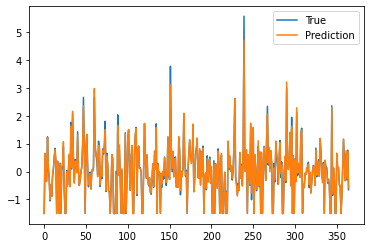

In [12]:
pred_365 = pred[0:365]
y_test_365 = y_test[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test_365, label='True')
ax.plot(pred_365, label='Prediction')

ax.legend()
plt.show()

In [13]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, pred)
print(r2)

0.989603977333124


In [14]:
mse = mean_squared_error(pred, y_valid, squared=False)
print(mse)

1.403067


In [17]:
pred= model.predict(x_valid)
from sklearn.metrics import r2_score
r2 = r2_score(y_valid, pred)
print(r2)

0.9895884443326104
